In [1]:
import glob
import math
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog

In [2]:
def load_images(files, num=0):
    imgs = []
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        imgs.append(img)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > 300:
        width_img = int(math.ceil(float(300) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

Cars in dataset: 8792; Non-cars in dataset: 8968


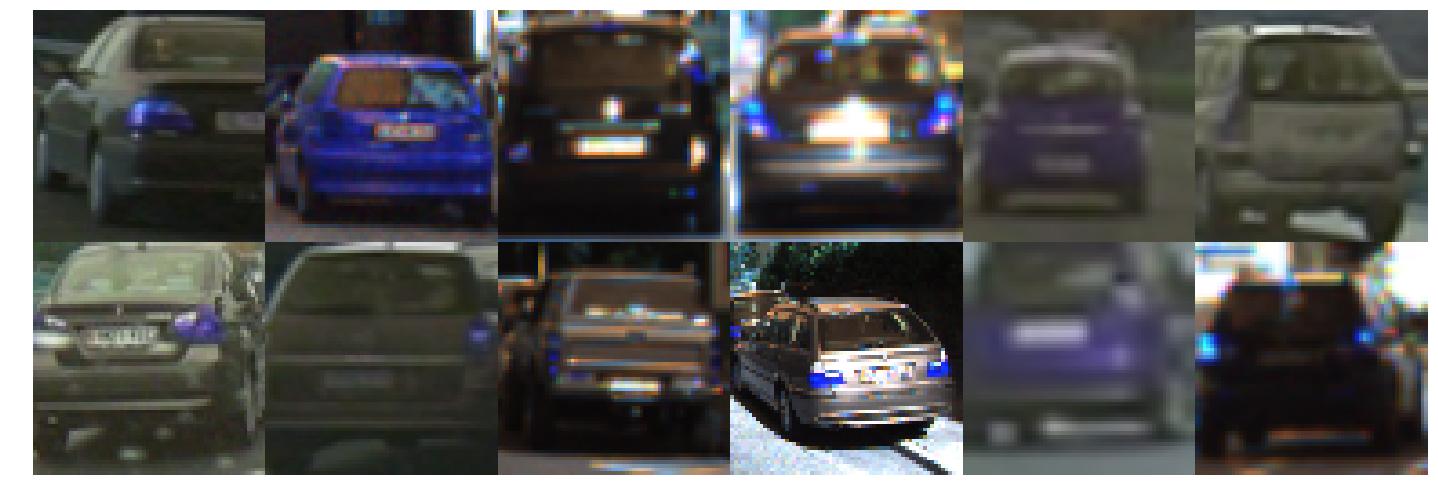

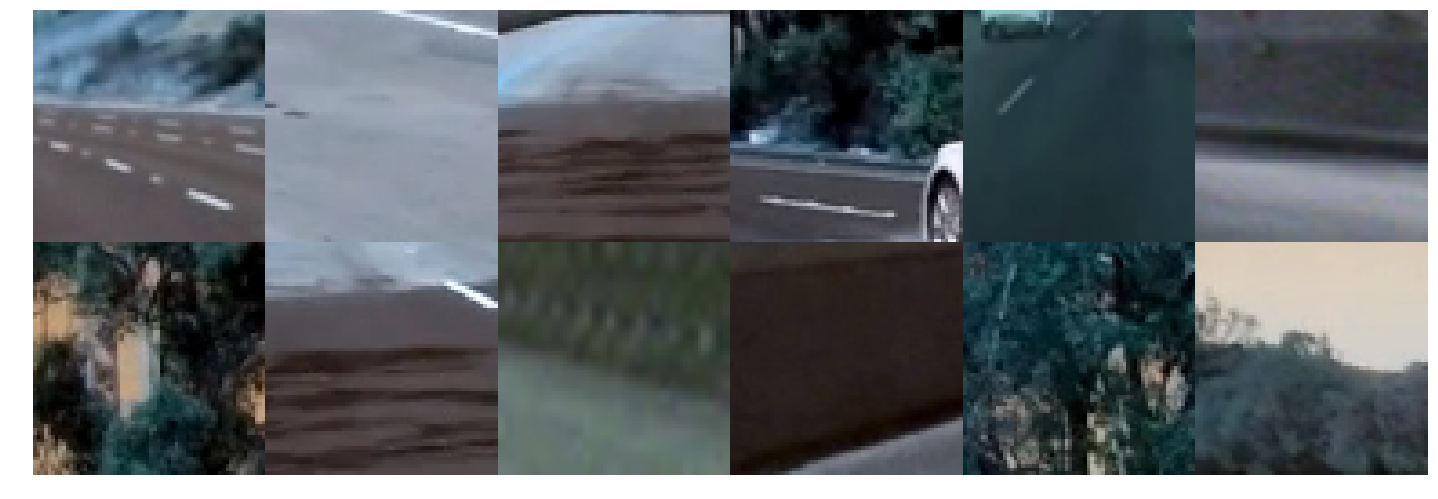

In [3]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

imgs_cars = load_images(files_cars, num=12)
display_image_set(imgs_cars, "cars")

imgs_noncars = load_images(files_noncars, num=12)
display_image_set(imgs_noncars, "noncars")

In [4]:
def to_colorspace(img, space='RGB'):
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img

def hog_features(img, orient=9, pix_per_cell=8, cell_per_block=8):
    ppc = (pix_per_cell, pix_per_cell)
    cpb = (cell_per_block, cell_per_block)
    features = []
    previews = []
    
    for channel in range(img.shape[2]):
        hog_feature, preview = hog(img[:,:,channel], orientations=orient, pixels_per_cell=ppc, cells_per_block=cpb, 
            visualise=True, feature_vector=True)
        features.append(hog_feature)  
        
        preview *= 255.0 / preview.max()
        preview = np.expand_dims(preview, 2)
        previews.append(preview)

    return features, previews

def hog_images(imgs):
    features = []
    preview_hog = []

    for img in imgs:
        preview_hog.append(img)

        img_cc = to_colorspace(img, 'YUV')
        feature, preview = hog_features(img_cc, 9, 8, 8)
        
        preview_hog.extend(preview)
        features.extend(feature)
        
    return features, preview_hog

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


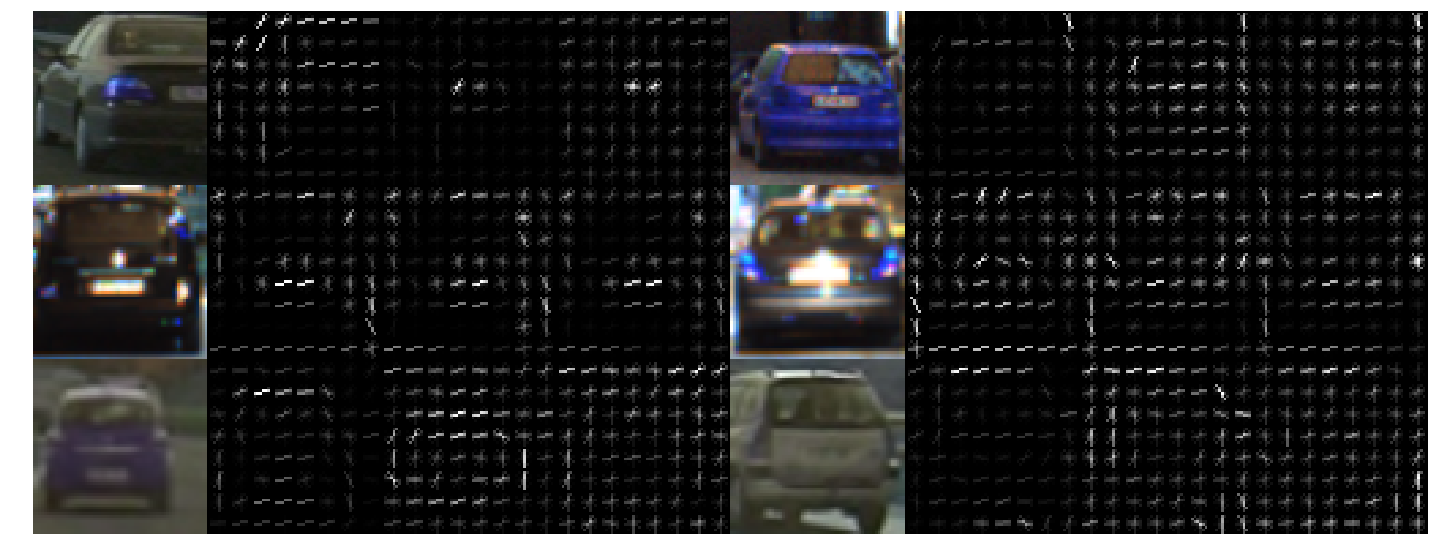

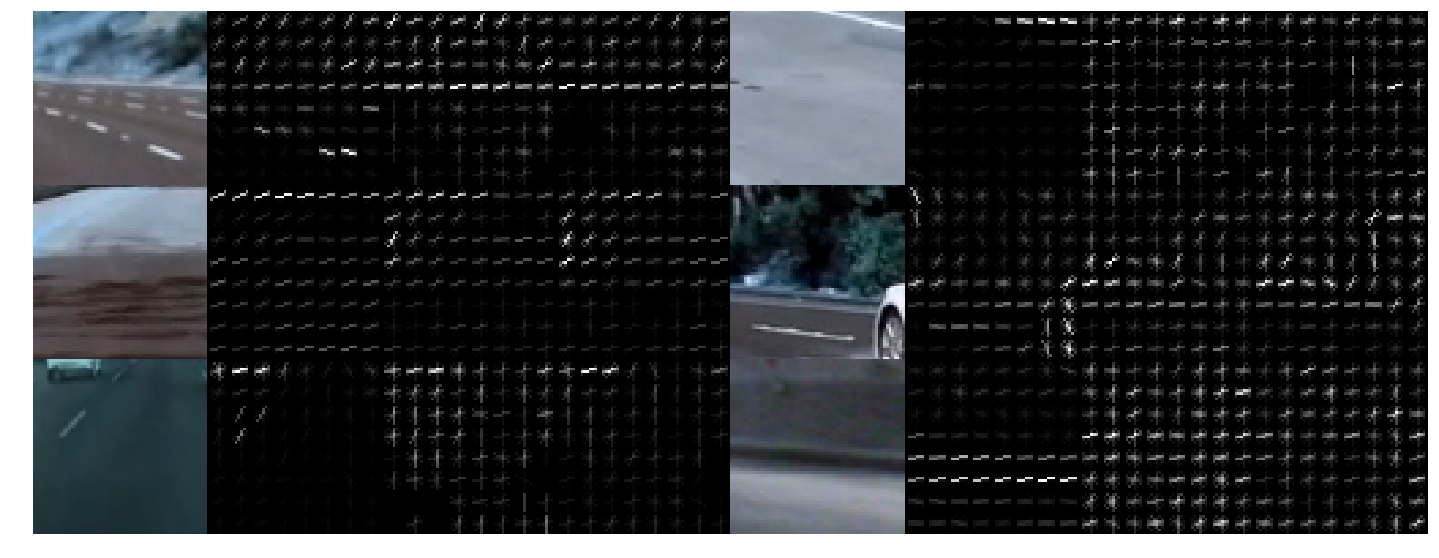

In [7]:
features_cars, preview_hog_cars = hog_images(imgs_cars[:6])
display_image_set(preview_hog_cars, "hog_cars", cols_num=8)

features_noncars, preview_hog_noncars = hog_images(imgs_noncars[:6])
display_image_set(preview_hog_noncars, "hog_noncars", cols_num=8)